# Modelo de detecção de sinais de depressão

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/depression_project/2020_INF425_NLP_SeReS/eda'

/content/drive/MyDrive/depression_project/2020_INF425_NLP_SeReS/eda


In [3]:
!pwd

/content/drive/MyDrive/depression_project/2020_INF425_NLP_SeReS/eda


In [4]:
%ls

 01_coleta_de_tweets.ipynb
 02_emotions_classifier.ipynb
 03_modelo_detecção_de_sinais_de_depressão.ipynb
 data/
 exercises/
 funcs/
'Multiclass Classification Problem with SoftMax.ipynb'
 README.md
 tests/
 twint/


In [5]:
#Importes
import os


#Funções próprias
import funcs
from funcs.clean_text import clean_text
from funcs.label_2_embedding import label2Embedding

#Visualização de dados
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

#Pré-processamento
!pip install emot
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

#Manipulação de dados
import nltk
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
import json
from sklearn.model_selection import train_test_split
import numpy as np

#Para uso do GloVe
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

#Redes neurais
import torch
from torch import nn

import time
from IPython.display import clear_output
import torch.nn.functional as F

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [6]:
CUDA_flag = torch.cuda.is_available() # a flag to check if CUDA is available for GPU use
CUDA_flag

True

In [7]:
cwd = os.getcwd()
cwd

'/content/drive/My Drive/depression_project/2020_INF425_NLP_SeReS/eda'

In [8]:
np.random.seed(666)
torch.manual_seed(666)

In [9]:
dataset = pd.read_csv('data/Dataset_Depressao_24_11_2020.csv', index_col=0)
dataset.head()

,usuario,texto,depressao,texto_traduzido
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\r\n\r\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\r\n\r\ngave internet for today https://t.co/I8SzMHuYV4
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face


In [10]:
dataset['texto_traduzido'].dtype

dtype('O')

In [11]:
dataset['texto_traduzido'] = dataset['texto_traduzido'].astype(str)

# Pré-processamento

## "Tradução" de emojis

In [12]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").split()))
        text = text.replace(":"," ")
    return text

In [13]:
dataset['documento_processado'] = dataset['texto_traduzido'].apply(lambda x: convert_emojis(x))

In [14]:
dataset.head()

,usuario,texto,depressao,texto_traduzido,documento_processado
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\r\n\r\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\r\n\r\ngave internet for today https://t.co/I8SzMHuYV4,broken into without a mother wanting to cancel a schizophrenic\r\n\r\ngave internet for today https //t.co/I8SzMHuYV4
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,Shaken by the whole situation of my life
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,then I am always happy for the achievements of my friends you know .... seriously
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,taking a deep breath not to punch anyone in the face


##Limpeza de texto

In [15]:
dataset["documento_processado"] = [tknzr.tokenize(word) for word in dataset["documento_processado"]]

In [16]:
dataset["documento_processado"] = [clean_text(sentence) for sentence in dataset["documento_processado"]]

In [17]:
dataset.head()

,usuario,texto,depressao,texto_traduzido,documento_processado
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\r\n\r\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\r\n\r\ngave internet for today https://t.co/I8SzMHuYV4,"[broken, without, mother, wanting, cancel, schizophrenic, gave, internet, today, https, t.co/i8szmhuyv4]"
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,"[nothing, absolutely, free, crowd, commenting, sports, profiles, casagrande's, photo]"
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,"[shaken, whole, situation, life]"
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,"[always, happy, achievements, friends, know, ..., seriously]"
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,"[taking, deep, breath, punch, anyone, face]"


In [18]:
dataset['depressao'].value_counts()

1    875
0    536
Name: depressao, dtype: int64

## Codificando o texto para o nosso modelo
Agora iremos fazer isso utilizando o GloVe

In [19]:
num_dims = 100

glove_file = datapath(cwd+f'/data/glove.6B.{num_dims}d.txt')
tmp_file   = get_tmpfile(cwd+f"/data/glove.6B.{num_dims}d_word2vec.txt")
_          = glove2word2vec(glove_file, tmp_file)

filename_txt = cwd+f"/data/glove.6B.{num_dims}d_word2vec.txt"
modelo = KeyedVectors.load_word2vec_format(filename_txt)

In [20]:
max_len = 280        # comprimento máximo da mensagem (em número de palavras)
encoded_docs = []    # inicializa a lista de documentos codificados

for sentence in dataset['documento_processado']: # para cada token
  encoded_d = [label2Embedding(t, modelo) for t in sentence]
  encoded_d = [vec.tolist() for vec in encoded_d if vec is not None]

  # adiciona o padding, se necessário
  padding_word_vecs = [np.zeros(num_dims).tolist()]*max(0, max_len-len(encoded_d)) 
  encoded_d = padding_word_vecs + encoded_d
  
  # trunca o documento e salva na lista de documentos codificados
  encoded_docs.append(encoded_d[:max_len]) 


encoded_docs_arrays = [np.vstack(sentence) for sentence in encoded_docs]

In [21]:
type(encoded_docs_arrays), type(encoded_docs_arrays[0]), encoded_docs_arrays[0].shape

(list, numpy.ndarray, (280, 100))

In [22]:
dataset['documento_codificado'] = pd.Series(encoded_docs_arrays)
dataset['documento_codificado'][0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.17614   ,  0.0020898 ,  0.14669999, ..., -0.52468002,
         0.76502001,  0.65232003],
       [-0.19938999,  0.37845999,  0.52092999, ..., -0.53718001,
         0.63884997,  0.57955003],
       [-0.36469001,  0.66465998,  0.16666999, ...,  0.54347003,
        -0.45087999,  0.21021999]])

In [23]:
dataset.shape

(1411, 6)

## Usando o modelo de classificação de emoções

In [24]:
from funcs.model_class import *

In [25]:
Model = torch.load(cwd+f'/../models/emotions_classifier_with_lasers_on_asteroids.pth')

In [26]:
Model.load_state_dict(torch.load(cwd+f'/../dicts/emotions_classifier_with_lasers_on_asteroids.dict',))
Model.eval()

moodClassifierWithLasersOnSteroids(
  (embedding): Sequential(
    (0): LSTM(100, 150, batch_first=True)
  )
  (ann): Sequential(
    (0): Linear(in_features=150, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
  (soft): Sequential(
    (0): LogSoftmax(dim=1)
  )
)

In [27]:
e = next(Model.embedding[0].parameters())
e.data

tensor([[ 0.0223, -0.2929,  0.1032,  ..., -0.3521, -0.4377,  0.0943],
        [ 0.0420, -0.1552, -0.0885,  ...,  0.0216, -0.0463,  0.0557],
        [ 0.0358,  0.2407, -0.2779,  ...,  0.0243, -0.1663,  0.1176],
        ...,
        [ 0.2751,  0.0214,  0.2411,  ...,  0.0812, -0.0197, -0.0986],
        [-0.2034,  0.0860,  0.3071,  ...,  0.0747,  0.0060, -0.1376],
        [ 0.3502, -0.1006,  0.1768,  ..., -0.1294, -0.1340,  0.3620]],
       device='cuda:0')

In [28]:
X_test = np.dstack(dataset['documento_codificado'].values).transpose(2,0,1)
X_test = torch.FloatTensor(X_test)
X_test.shape

torch.Size([1411, 280, 100])

In [29]:
X_test.shape, type(dataset['documento_codificado'][0])

(torch.Size([1411, 280, 100]), numpy.ndarray)

In [30]:
#preds = Model.forward(X_test)

In [31]:
#dataset['documento_processado'][0]

In [32]:
#Model.forward(torch.FloatTensor(dataset['documento_processado'][0]).reshape(1,-1,num_dims))

In [33]:
#X_test[0]

In [34]:
#dataset["previsoes"] = [torch.exp(pred).detach().numpy() for pred in preds]
#dataset.head()

## Preparando o input (Aka a nova distribuição média de emoções)

Devemos pegar as softmax das emoções de vários tweets de um mesmo usuário e transformar em um só para o nosso modelo final

In [35]:
dataset.shape

(1411, 6)

In [36]:
df_emotions = dataset.copy()
df_emotions.set_index('usuario', inplace=True)

In [37]:
df_final = pd.DataFrame(columns=['user','emotions', 'depression'])

In [38]:
users = dataset['usuario'].unique()
emotions_users = []
tweets_texts = []
y = []
min_tweets = 6

for user in users:
     df_user = df_emotions.loc[user][:min_tweets]
     n_fill = min_tweets - df_user.shape[0]

     X_test = np.dstack(df_user['documento_codificado'].values).transpose(2,0,1)

     X_test = torch.FloatTensor(X_test)

     if CUDA_flag:        
      X_test = X_test.cuda()
    
     result = Model.forward(X_test)

     tweets_texts.append(df_user['texto'].tolist())
     y.append(df_user['depressao'][0])
     emotions_users.append([[-1.79175947, -1.79175947, -1.79175947, -1.79175947, -1.79175947, -1.79175947]]*n_fill+result.cpu().detach().numpy().tolist())     

In [39]:
X_df = pd.DataFrame(columns=['user', 'tweets', 'depression'])
X_df['user'] = users
X_df['tweets'] = tweets_texts
X_df['depression'] = y

X_df.shape

(305, 3)

In [40]:
X_df.loc[1]['tweets'][0]

'Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande'

In [41]:
sum(y), len(y)

(169, 305)

In [42]:
emotions_users[0]

[[-3.3126003742218018,
  -8.495238304138184,
  -0.03795786574482918,
  -11.87506103515625,
  -7.395900249481201,
  -23.554868698120117],
 [-3.981623649597168,
  -7.164429664611816,
  -0.8039312362670898,
  -4.780918598175049,
  -0.6450878381729126,
  -14.96420955657959],
 [-3.0216867923736572,
  -4.068519592285156,
  -6.317107677459717,
  -6.368907451629639,
  -0.0718628391623497,
  -14.46139144897461],
 [-8.123332977294922,
  -9.630788803100586,
  -13.572898864746094,
  -0.00036399890086613595,
  -14.610052108764648,
  -19.479333877563477],
 [-0.0015355474315583706,
  -7.0584306716918945,
  -9.176801681518555,
  -9.038472175598145,
  -7.730597019195557,
  -11.263001441955566],
 [-0.009175751358270645,
  -5.326103687286377,
  -9.135053634643555,
  -7.6356706619262695,
  -5.609367847442627,
  -11.005932807922363]]

In [43]:
np.array(emotions_users[0:3]).shape

(3, 6, 6)

In [44]:
X_numpy = np.array(emotions_users)

In [45]:
Y_numpy = np.array(y).reshape(-1, 1)

In [46]:
Y_numpy.shape, X_numpy.shape

((305, 1), (305, 6, 6))

##Train Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_numpy, Y_numpy, stratify=Y_numpy, test_size=0.50, random_state=666, shuffle=True)

In [48]:
Y_df = X_df['depression']
X_df = X_df

In [49]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, Y_df, stratify=Y_df, test_size=0.50, random_state=666, shuffle=True)

In [50]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((152, 6, 6), (152, 1), (153, 6, 6), (153, 1))

In [51]:
X_train_df.shape, y_train_df.shape, X_test_df.shape, y_test_df.shape

((152, 3), (152,), (153, 3), (153,))

In [52]:
y_test_df.values.reshape(-1) == y_test.reshape(-1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Criando ***El Modelo***

In [53]:
class depression_detection(nn.Module):
  '''
  Modelo classificador de emoções
  '''
  # ----------------------------------------------#
  # Método construtor
  def __init__(self, n_in, num_layers, num_units, n_units_lstm, dim_lstm): 

    super().__init__()  
    ann_seq       = [] 
    lstm_seq      = []

    #--------------------------------------------------------------------------#
    # LSTM: 
    lstm_seq.append(nn.LSTM(input_size=dim_lstm, hidden_size=n_units_lstm, 
                                  num_layers=1, batch_first=True))
    #--------------------------------------------------------------------------#
    # ANN: Rede Neural Artifical Tradicional, com regressão logística na saída
    for i in range(1, num_layers):
      ann_seq.append(nn.Linear(in_features=num_units[i-1], out_features=num_units[i]))
      ann_seq.append(nn.ReLU(inplace=True))
    ann_seq.append(nn.Linear(in_features=num_units[-1], out_features=1))
    ann_seq.append(nn.Sigmoid())
    
    #--------------------------------------------------------------------------#
    # "merge" de todas as camamadas em uma layer sequencial 
    # (uma sequência para cada etapa)
    self.ann= nn.Sequential(*ann_seq)           # etapa ANN
    self.lstm_seq= nn.Sequential(*lstm_seq)     # etapa de lstm
    #--------------------------------------------------------------------------#

  def forward(self, x): 
    '''
    Processamento realizado ao chamar y=modelo(x)
    '''
    _, (x, _) = self.lstm_seq(x)  # aplica a etapa de embedding
    x = x.transpose(1,0)   # inverte dimensões (força "batch first" no hidden state)
    x = self.ann(x)        # passa o embedding médio pelas camadas da ANN
    x = x.view(x.shape[0],-1)
    return x  

In [54]:
def train_loop(model, data_train, data_test, max_epochs = 1000, print_iters = 5):
  X_train, Y_train = data_train
  X_test, Y_test = data_test

  if CUDA_flag: # usar GPU?
      X_train = X_train.cuda()
      Y_train = Y_train.cuda()
      X_test = X_test.cuda()
      Y_test = Y_test.cuda()

  losses = []
  accs = []
  for i in range(max_epochs): # para cada época

      #-----------------------------------#
      # INÍCIO DO WORKFLOW DO TREINAMENTO #
      # 
      # Add mistura
      Y_pred = model.forward(X_train)         # apresente os dados de entrada para o modelo, e obtenha a previsão  
      loss = criterion(Y_pred, Y_train)                      # calcule a perda (o custo, o erro)
      optimizer.zero_grad()                   # inicialize os gradientes
      loss.backward()                         # backpropagation sobre a perda atual (cálculo dos novos gradientes) 
      optimizer.step()                        # atualização dos parâmetros da rede utilizando a regra do otimizador escolhido

      
      # FIM DO WORKFLOW DO TREINAMENTO    #
      #-----------------------------------#

      # ------ Bloco Opcional ------ #
      # Salvando métricas
      losses.append(loss)                     # salvando a perda atual
      acc = calc_accuracy(Y_pred, Y_train)     # calcula a taxa de acerto atual
      accs.append(acc)
      
      # Imprimindo resultados parciais
      if i % print_iters ==0: # a cada 10 iterações
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}') 
      #-----------------------------------#

  #----------------------------------------------------------------------------# 
  print('\n# Finished training!')
  print(f'# --> epoch: {i}  \n# --> initial loss: {losses[0]:10.8f} ,  \n# --> accuracy: {acc:2.8f} , \n# --> final loss: {losses[-1]:10.8f}')
  
  # retornando resultados
  return model, losses, accs

# Redefinindo cálculo da taxa de acerto 
def calc_accuracy(y_pred, y_true):
  ''' Helper function para calcular a taxa de acerto deste exemplo.
  '''
  num_hits  = torch.sum(torch.round(y_pred)==y_true).cpu().numpy()
  num_total =  float(y_true.numel())
  acc=  num_hits/num_total
  return acc

In [55]:
data_train = (torch.FloatTensor(X_train), torch.FloatTensor(y_train))

data_test = (torch.FloatTensor(X_test), torch.FloatTensor(y_test))

## Melhorando com hiperparâmetros

In [56]:
# Código baseado no github do professor Bruno Fontana. 
from sklearn.model_selection import ParameterGrid

Ajustar_Hiperparametros = True     

n_units_lstm = num_dims
param_dict = {}
param_dict['learning_rate'] = np.logspace(-4, -2, 10)
# np.linspace(0.01, 0.1, 10) # [0.1, 0.01, 0.001] # exemplos de buscas: np.linspace(1e-2,5e-2,5) ou np.logspace(-3,-1,20)
param_dict['layers'] = [
                        (2, [n_units_lstm, 25]),
                        (3, [n_units_lstm, 75, 25]),
                        (4, [n_units_lstm, 100, 75, 25]),
                        (5, [n_units_lstm, 200, 100, 75, 25])
                        ]
                        # (2, [6, 48]),
                        # (2, [6, 52]),
                        # (3, [6, 48, 8]),
                        # (3, [6, 48, 16]),
                        #(3, [6, 48, 32]),
                        #(3, [6, 48, 48]),
                        #(3, [6, 48, 64])]
                        # (4, [6, 100, 50, 25]), 
                        # (5, [6, 200, 100, 50, 25]),
                        # (6, [6, 400, 200, 100, 50, 25])]              # exemplos de buscas: np.arange(start=1,stop=4)
# param_dict['num_units'] = [[6, 100, 50, 25], [6, 200, 100, 50, 25]]         # exemplos de buscas: np.arange(10,15)

param_dict['max_epochs']= [1000, 2000, 3000, 4000]     # maximum number of iterations running over the training set

Num_HyperParams_to_test = len(ParameterGrid(param_dict))

In [57]:
criterion = nn.BCELoss() # binary cross-entropy

if Ajustar_Hiperparametros:
  acc_test_list = []
  max_acc_test = -np.inf
  best_params = None
  idx_best = None
  for idx, params in enumerate(ParameterGrid(param_dict)):
    learning_rate = params['learning_rate']      # learning rate for parameter updates
    L, num_units = params['layers']                              # depth of ANN (number of hidden layers)
    #num_units = params['num_units']                    # 2**Nu_exp = Number of units per HL
    max_epochs = params['max_epochs']            # num. of iterations over the full dataset

    print(f'Testing parameters {idx}/{Num_HyperParams_to_test}: {params}')

    torch.manual_seed(666)
    model = depression_detection(n_in=6, num_layers=L, num_units=num_units, n_units_lstm=n_units_lstm, dim_lstm=6)
    if CUDA_flag:
      model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
    model, losses, accs = train_loop(model, data_train, data_test, max_epochs=max_epochs, print_iters=1000)

    # print(f'Model {model}',f'Criterion: {criterion}',f'Optimizer: {optimizer}',sep=2*'\n')

    X_test, Y_test = data_test

    if CUDA_flag:
      X_test = X_test.cuda()
      Y_test = Y_test.cuda()

    with torch.no_grad():
      Y_pred = model(X_test)
      num_hits  = torch.sum(torch.round(Y_pred)==Y_test).cpu().numpy()
      num_total =  float(Y_test.numel())
      acc_test = num_hits/num_total
      # print(f'TEST SCORE: Torch loss {acc_test.item():10.6f}  (ANN)')

    if acc_test > max_acc_test:
      max_acc_test = acc_test
      best_params = params
      losses_best, acc_best = (losses, accs)
      idx_best = idx
      best_model = model

    acc_test_list.append(acc_test)


    # clear_output(wait=True)
  print("best_params", best_params, "acc_test_list", acc_test_list, "idx_best", idx_best, "acc_best", acc_test_list[idx_best], sep="\n")

else:
  model = depression_detection(n_in=6, num_layers=2, num_units=[6,48])
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) 
  best_model, losses_best, acc_best = train_loop(model, data_train, data_test,max_epochs=2000, print_iters=50)

Testing parameters 0/160: {'layers': (2, [100, 25]), 'learning_rate': 0.0001, 'max_epochs': 1000}
epoch:  0  loss: 0.68813843

# Finished training!
# --> epoch: 999  
# --> initial loss: 0.68813843 ,  
# --> accuracy: 0.98684211 , 
# --> final loss: 0.02142296
Testing parameters 1/160: {'layers': (2, [100, 25]), 'learning_rate': 0.0001, 'max_epochs': 2000}
epoch:  0  loss: 0.68813843
epoch: 1000  loss: 0.02141436

# Finished training!
# --> epoch: 1999  
# --> initial loss: 0.68813843 ,  
# --> accuracy: 0.98684211 , 
# --> final loss: 0.01895097
Testing parameters 2/160: {'layers': (2, [100, 25]), 'learning_rate': 0.0001, 'max_epochs': 3000}
epoch:  0  loss: 0.68813843
epoch: 1000  loss: 0.02141436
epoch: 2000  loss: 0.01899121

# Finished training!
# --> epoch: 2999  
# --> initial loss: 0.68813843 ,  
# --> accuracy: 0.98684211 , 
# --> final loss: 0.01845330
Testing parameters 3/160: {'layers': (2, [100, 25]), 'learning_rate': 0.0001, 'max_epochs': 4000}
epoch:  0  loss: 0.68813843

In [58]:
print(best_model)

depression_detection(
  (ann): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=25, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (lstm_seq): Sequential(
    (0): LSTM(6, 100, batch_first=True)
  )
)


In [59]:
# Model, losses, accs = train_loop(model, data_train, data_test, max_epochs=1000, print_iters=1) # note que o modelo é sobrescrito pela saída treinada

In [60]:
X_train = torch.FloatTensor(X_train)

In [61]:
if CUDA_flag:
  X_train = X_train.cuda()

In [62]:
Y_pred = best_model(X_train)

#Visualizando resultados

##Gráfico de Loss e Accuracy

In [63]:
def plot_loss_and_accuracy(losses, accs):

  fig, ax_tuple = plt.subplots(1, 2, figsize=(16,6))
  fig.suptitle('Loss and accuracy')

  for i, (y_label, y_values) in enumerate(zip(['BCE loss','Accuracy'],[losses, accs])):
    ax_tuple[i].plot(range(len(y_values)),  y_values, label='train')
    ax_tuple[i].set_xlabel('epochs')
    ax_tuple[i].set_ylabel(y_label)
    ax_tuple[i].legend()
  
  ax_tuple[1].set_ylim([0,1])

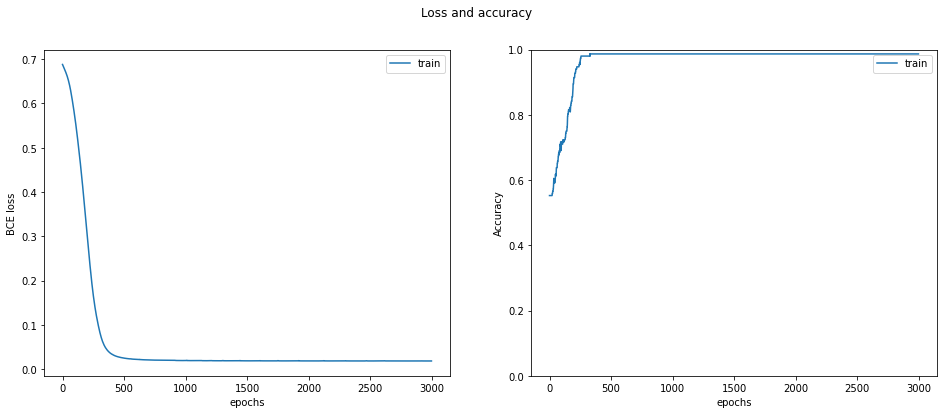

In [64]:
plot_loss_and_accuracy(losses_best, acc_best)

##Confusion Matrix

In [65]:
Y_pred = best_model(X_test)
#Y_pred[:10]

In [66]:
Y_test.dtype

torch.float32

In [67]:
X, Y = data_test

if CUDA_flag:
  X = X.cuda()
  Y = Y.cuda()

with torch.no_grad():
    Y2 = best_model(X)
    num_hits  = torch.sum(torch.round(Y2)==Y).cpu().numpy()
    num_total =  float(Y.numel())
    acc_test = num_hits/num_total

acc_test

0.6797385620915033

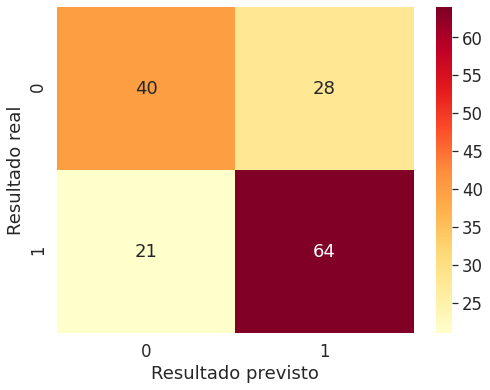

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1.5)

# confusion matrix daora TEM Q MELHORAR
def plot_conf_mat(y_test, y_preds, norm=None):
   fig, ax = plt.subplots(figsize=(8, 6))
   ax = sns.heatmap(confusion_matrix(y_test, y_preds, normalize=norm),
                   annot=True,
                    fmt="d",
                    cmap="YlOrRd")
   plt.xlabel("Resultado previsto")
   plt.ylabel("Resultado real")


plot_conf_mat(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy().round())

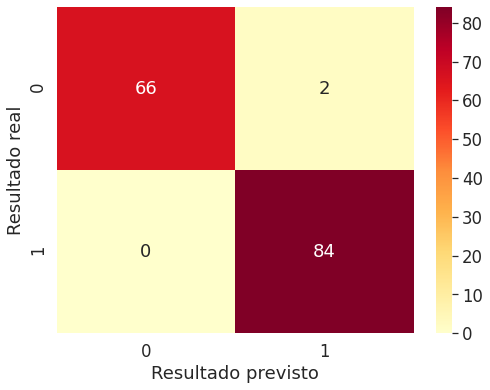

In [69]:
Y_predtrain = best_model(X_train)
plot_conf_mat(y_train, Y_predtrain.detach().cpu().numpy().round())

## F1 Score

In [70]:
from sklearn.metrics import f1_score

f1_score(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy().round())

0.7231638418079096

## Recall Score

In [71]:
from sklearn.metrics import recall_score

recall_score(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy().round())

0.7529411764705882

##Precision

In [72]:
from sklearn.metrics import precision_score

precision_score(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy().round())

0.6956521739130435

## ROC Curve

In [73]:
# função pra plotar a ROC curve

def plot_roc_curve(fpr, tpr):
    
    plt.plot(fpr, tpr, color="orange", label="ROC")  
    plt.plot([0,1],[0,1], color="darkblue", linestyle="--", label="Guessing")
    
    plt.xlabel("Taxa de falsos positivos  (fpr)")
    plt.ylabel("Taxa verdadeira positiva (tpr)")
    plt.title("Receiver Operating Characteristics (ROC) curve")
    plt.legend()
    plt.show()

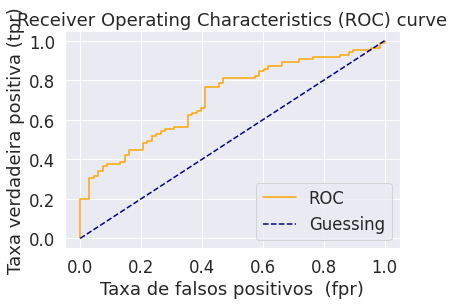

In [74]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy())
plot_roc_curve(fpr, tpr)

## ROC/AUC Score

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy())

0.7084775086505191

## Classification Report

In [76]:
from sklearn.metrics import classification_report

# compare the truth labels to the predicted labels
print(classification_report(Y_test.detach().cpu().numpy(), Y_pred.detach().cpu().numpy().round()))

              precision    recall  f1-score   support

         0.0       0.66      0.59      0.62        68
         1.0       0.70      0.75      0.72        85

    accuracy                           0.68       153
   macro avg       0.68      0.67      0.67       153
weighted avg       0.68      0.68      0.68       153



#Confusion Matrix

In [77]:
def visualizar_user(nome):  

  usuario_teste = nome
  id = X_test_df.reset_index().query('user == @usuario_teste').index.values
  emotions_user = torch.exp(X_test[id].view(-1, 6))*100
  emotions_user = emotions_user.detach().cpu().numpy()

  plt.figure(figsize=(10, 6))
  plt.bar(emotions, emotions_user.mean(axis=0), color=['lightcoral', 'khaki', 'bisque', 'lightsteelblue', 'lightgreen', 'thistle'])
  plt.title("Distribuição de emoções")
  plt.show()

  sns.heatmap(emotions_user[::-1].T, yticklabels=emotions, cmap='YlOrBr', vmin=0, vmax=100)
  plt.title("Emoções ao longo do tempo")


In [78]:
moods = {"Anger": 0, "Fear" : 1, "Joy" : 2, "Love" : 3, "Sadness" : 4, "Suprise" : 5}
sdoom = {0 : "Anger", 1: "Fear", 2: "Joy", 3: "Love", 4: "Sadness", 5: "Suprise"}
emotions = list(moods.keys())

In [79]:
emotions

['Anger', 'Fear', 'Joy', 'Love', 'Sadness', 'Suprise']

##False Negative

In [80]:
Ytrue1 = Y_test.detach().cpu().numpy() == 1
Ypred0 = Y_pred.detach().cpu().numpy().round() == 0

In [81]:
X_test_df[Ytrue1.reshape(-1) & Ypred0.reshape(-1)]  #Onde era verdadeiro e foi previsto falso  (FALSO NEGATIVO)

,user,tweets,depression
173,hadassa_rebecah,"[eu não aguento mais ter pais controladores ,eu não aguento MAIS tudo isso, eu tenho um ódio tão grande d minha mãe ser assim cmg ,ela me faz tanto mal e não percebe cara ,dps q eu me afundo em crise dps q eu começo a ter depressão dnv ela AINDA pergunta o pq ? OLHA PRO SEU PRÓPRIO RABO CARALHO, todo dia é isso velho ,todo dia ,eu não aguento mais ficar dentro de casa cm essas pessoas TÓXICAS não dá ,o maior motivo pra mim não desistir das coisas teria q ser minha mãe e tá sendo totalmente ao contrário, Fui dormir 5 hrs nesse caralho pra acorda agora ,vai toma no cuuuuuuuuuuu, não poder fazer merda nenhuma o pior é morar na puta q pariu e ser obrigada além d passar a semana toda em casa ter q passar o fds, oq me deixa mais revoltada , é q minha mãe viu a última vez o quão mal eu tava ,eu falando q iria me suicidar e a única coisa q ela fez foi oq ? Não me ajudar e mais uma vez demonstrar q tá pouco se fudendo ,até pq a minha foto é mentira e ""drama"" e a dos outros é verdade né?.]",1
128,BielBravo1,"[tenho nem roupa e nem namorado para isso,enfim a solidão https://t.co/nza6bVUfqw, Eu,Lívia e a Mariana planejando nossa viagem pro México https://t.co/IkMLHybM9X, eis q um boy vem te ver 🤦‍♂️ https://t.co/uTtCcxmdFo, Pessoas: nossa sua mae é tao legal...\r\n\r\nEu: KKKKKKK nao conhece ela ainda,mal sabe q se eu tenho depressão é por causa dela, ta eu sei que nao temos nada alem de sermos amigos,mas eu tenho ciumes 🤦‍♂️]",1
151,MaraMPB,"[Os filmes do Charlie Kauffman parecem sonhos estranhos.Estou Pensando em Acabar com Tudo me lembrou um episódio de Castle Rock que mostra a perda de senso temporal q a Sissy Spacek tem devido ao Alzheimer. Ah, e Toni Collette, como sempre, maravilhosa., Billie Joe fez cover de uma das músicas que eu mais amo: White Wide World do Wreckless Eric Obrigada, BJ, salvou meu dia! https://t.co/4psKh5ZrF6, Eu tô com ódio de quem tá aglomerando, sim! Desde o dia 16/03 eu tô trancada em casa c meus pais de 74 e 78 anos pq minha irmã é médica e meu irmão bancário e não pararam de trabalhar. Como estou tendo EAD sou a única q pode ajudar a cuidar deles e da casa - sem empregada., Tenho depressão e meu pai ansiedade, estamos lidando com os danos que o isolamento causa à saúde mental e qto mais tempo voces desrespeitam as diretrizes da OMS mais tempo o grupo de risco tem q ficar trancado em casa.]",1
150,achrystinaoc,"[Gente pra eu odiar alguma coisa ela tem que ter relevância na minha vida, de criança mesmo só quero distancia já basta as que eu sou obrigada a conviver https://t.co/AqiWDSZs5B, Gente- https://t.co/bvQmxyidVe, Resolveu tomar as dores de outro que não tem nada com a nossa vida e disse que eu não mereço o que tenho e que minha depressão é mentira, esperei sei la quantos dias pra um oi sequer, essa semana eu queria no mínimo um pedido de desculpa, mas não ganhei nada, Ai as bookstan me irrita com essa mania de se achar superior a todo mundo]",1
229,fariananny1,"[Morro um pouco a cada dia, e a cada respirada durante os dias exaustos eu me afogo nas trevas \r\n#depressao #help_me #holdmyhand, Estou nos dias em quem naonqueria nem ter saido da cama. Embora eu sei que não foz nada de errado, mas a sensação é pior do que se eu tivesse feito #badtrip #depressão \r\n#momentosdebad, Quando eu penso no futuro, sei que ele é incerto, pois minha mente me auto sabota. Durante anos me auto destruí, e agora dia a pós dia me reconalstruo.]",1
236,Tripacs,"[Era so um abraço, se pa... sincero e tal.\r\nMaybe uma conversa jogada fora, idk.\r\nA que ponto de caos cheguei pqp, Muito concorrencia, pego meu banquinho e saio de fininho, É só ficar inerce que ja vem merda na cabeça e a tristeza bate.\r\nQueria saber ate quando vou ficar assim. \r\nEu so queria um carinho btfe?\r\nSla foda-se, algo que me fizesse esquecer que tenho depressao. Vsf que odio, É, virado again... pessimo]",1
126,whosritad,"[Pensando em já ir de zolpi, Estomatopatologia, imaginologia e integração clínic

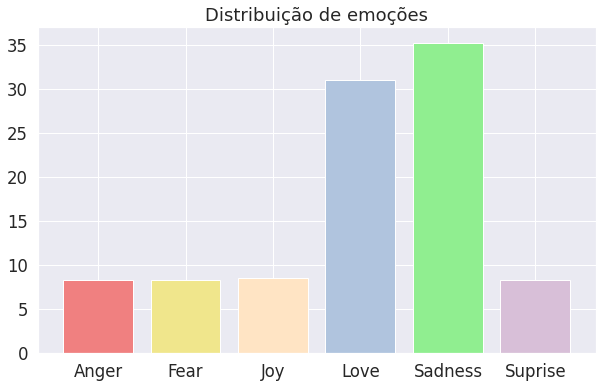

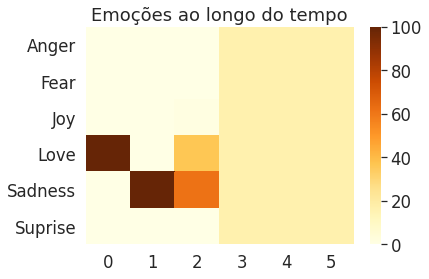

In [82]:
visualizar_user('MATHEUS_YURIII')

##Falsos Positive

In [83]:
Ytrue0 = Y_test.detach().cpu().numpy() == 0
Ypred1 = Y_pred.detach().cpu().numpy().round() == 1

In [84]:
X_test_df[Ytrue0.reshape(-1) & Ypred1.reshape(-1)]  #Onde era falso e foi previsto verdadeiro  (FALSO POSITIVE)

,user,tweets,depression
257,idfchae,"[procurem ajuda https://t.co/oqrgrSUXOc, Parem de ser gostosos na tml eu tenho depressão, Apaguem essa merda de imaginar a jennie como namorada eu tenho depressao gatilho mastigo espinho na hora, Já a jennie foi desde o início com uma bolsa da chanel pra não insinuarem que ela é pobre afinal sua mãe é doutora e o pai um advogado muito bem sucedido do qual a fornecem estudo em uma das escolas mais caras de s https://t.co/KaTFKROfvd]",0
156,vitouseless,"[Quebrando o Tabu, vo faze Peripecias, OWOWOWOWOW PETER PAN NAO MALUCO EU TENHO DEPRESSAO PARAR PARAR ACALMAR PETER PAN NAO ME DEIXA SERIAMENTE EM ESTADO PREOCUPANTE, esto co uma sensaçao Horrivel n sei oq eh isso, meu deus quem colocou thread disso na tml eu ia falar brincando que tenho depressao gravissima de meme mas acabou que me deixou realmente Mal dps de ver pelo amor de deus, nem fodendo que eu vo volta nos episodio anterior pra ve quem sao esses maluco aki slk tenho Depressao Gravissima super Avancada nem fodeno que vo volta pra ve quem sao esses cara phodase 🍃💯]",0
148,Dandaodofloow,"[Boa noite, família! Fui na igreja Deus abençoou e amanhã tem feriado.\r\n\r\nSó penso em dormir e nem quero ver a cara de ninguém.\r\n\r\nObrigado Dom Pedro, você é mil! Mais um dia pra gente ficar vagabundando, Domingão e depois do almoço bate aquela DPP (depressão pós prato) e não tenho disposição nem de brigar com o cachorro.\r\n\r\nQuarentena é um eterno feriado, não sei de quem foi a ideia de emendar o carnaval com o natal\r\n\r\nJá sabemos que não dá certo. É isso, descansem e aproveitem. Tmj, Finalmente sai com a gata ontem e foi aquela felicidade, esqueci até de dar boa noite e bom dia. Cabeça tava na lua.\r\n\r\nE até agora não a tirei da mente, será que é amor ou fogo no rabo? Veremos nos próximos capítulos\r\n\r\nInvistam no amor, mas não no amor dos outros. Tenha um pra vc., Acordando todo animado, porque o feriado tá aí e ngm pode roubar nossa alegria.\r\n\r\nBora esquecer o corona e ser feliz ao menos uma vez nessa quarentena. Quem não se movimenta fica Depre.\r\n\r\nEntão, de um pulo da cama, agradeça por hoje e simbora seus bando de gado. Pula, pula, pula!]",0
21,mingyubabie,"[ela não é triste mas quando eu to triste ela me soa sofrida aos ouvidos parece que estou tomando uma facada de nam woohyun, sim eu adoro ouvir gente xingando o que eu gosto por favor continua vc tem razão mesmo 🙏🏽🙏🏽, que delícia comer e sentir tudo com gosto de papelão eu to amando, olha só se não é uma gay branca, woozi pinta do cabelo igual o do nishinoya e eu digo se esperava, gente que vídeo pavoroso https://t.co/Npg5Fo8YtX]",0
238,panteraalada,"[Me dizem assim: Siga seus instrumentos vá sempre pela sua intuição. É o que tenho feito ultimamente., Não deixe que as pessoas te façam desistir daquilo que você mais quer na vida. Acredite. Lute. Conquiste. E acima de tudo, seja feliz!\r\n\r\nDesconhecido, Alguém aí já ouviu falar em teorias xamânicas como exp. Deixar sair seu animal interior? O que acham disso qual o animal que vcs se identificam?, Olhar pra lua e dar uma boa respirada me revigora!, Difícil ser vc mesma depois de uma decepção ou uma dor tão forte na alma como a #depressao ou vc fica louca de vez ou vc fica fria.]",0
226,swiftiegguk,"[AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA https://t.co/lZ3t1c04oi, olho pras coisas q eu tenho que fazer e me dá depressão, LADEIROU SIM EIN VAI SE FUDE CARALHO]",0
207,defenseIena,"[nao aguento mais os medicos falando que tenho depressao kk cara? eu ate dou risada, falando meu estado de saude aqui esperando q algum medico online me ofereça uma consulta e fale oq tenho (depressao), o ruim eh que ja fui alguem muito alegre e as pessoas se acostumaram com aquela versao feliz minha ai agora que tenho depressao todo mundo ja sabe que sou capaz de sorrir isso que eh foda]",0
252,EuricoAlves15,"[Ah vey, quando bater a #depressao, #bad, #tristeza ou slá o que der em vc, vá até ao espelho mais próximo e cante em alta voz: 

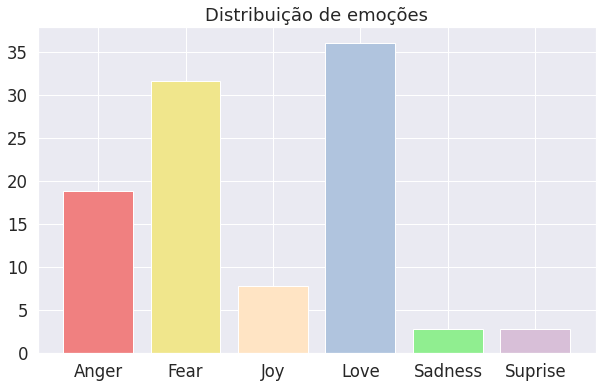

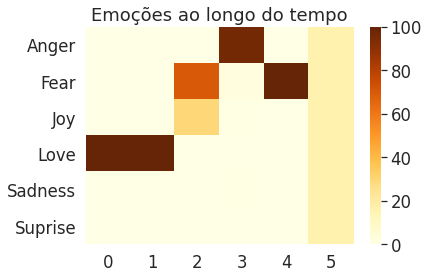

In [85]:
visualizar_user('mvtxsl')

## True Positive

In [86]:
Ytrue1 = y_test == 1
Ypred1 = Y_pred.detach().cpu().numpy().round() == 1

In [87]:
X_test_df[Ytrue1.reshape(-1) & Ypred1.reshape(-1)]  #Onde era verdadeiro e foi previsto verdadeiro  (True positive)

,user,tweets,depression
190,JTdeMoraes,"[Antologia Acústica de Zé Ramalho https://t.co/2YHr1qE6R2 #NowPlaying, cerveja pra curar a ressaca do plantão super indico, Veja esta foto do Instagram de @epidemioinformacao https://t.co/voGYK0pQa5, É o seguinte, ando pensando, em como retomar minha vida acadêmica perdida nesses últimos três anos que descobri a depressão. Quero só chorar, mesmo com 2 anos de tratamento, não tenho forças. Meu dda se perde no perfeccionismo e me vejo fracassar. #saudemental #SetembroAmarelo, Tudo pronto! Daqui a 30 minutinhos vai sair um delicioso bolo de coco low carb, pena que vou comer sozinha com um maravilhoso café (deboche para quem me deixou por um hambúrguer).\r\n\r\nSim, eu sou recalcada!]",1
201,onmysblock,"[eu me sinto tão impotente vendo isso pq eu não posso fazer mais nada alem de assinar uma petição e isso me destrói \r\nricardo salles seu vagabundo de merda espero q vc morra queimado seu verme dos infernos @rsallesmma https://t.co/NrI22mucG5, essa é pra refletir https://t.co/gXbkMUFm4w, acabei de ver into the night e nossa amei eu tava esperando uma versão ruim de manifest mas não tem nada a ver, Tenho 21 anos e sofro de depressão à 3 anos.\r\nentão vou fazer uma promessa a cada rtt que tiver vai ser 1 dia ke sentir deprimida e toda vez que eu sentir triste, vou pegar uma das pessoas que deu rtt e vou agradecer\r\nex : ( obrigada @ por ter salvo a minha vida ), qnd entrou um no meu ouvido em 2017 eu fui na médica e ela jogou um jato de água com uma seringa pra ele sair fiquei tontissima https://t.co/CDkY0xsAjO]",1
295,CaetanoVf,"[cara eu olhando pra foto dela ontem me apaixonei mais ainda, gg diagnósticado com depressão e vai lá e minha mae me ajuda falando q eu só fico no quarto o dia inteiro e q eu n fasso nd e q sou um vagabundo aaaa vou pular da ponte vey n to alguéntanto, ela é perfeita PERFEITA aaaaaa, minha meta era contatos de A a Z mal cheguei no a e me apaixonei, toma no cu ta ansioso pra caralho pra me declarar pra ela se fude]",1
276,luaratizot,"[acabei de me tocar que eu não faço as atividades do ead tem mais de duas semanas eu vou morrer jesus amado simplesmente esqueci que ainda faço faculdade, as coisas que eu mais amo no mundo minha familia minha cachorra os bts, SETENTA E QUATRO PORCENTO MAIOR https://t.co/GLecwBZFGJ, que agonia olhar os stories do instagram e perceber que tá todo mundo saindo, MEU DEUS EU ODEIO ESSE FILHO DA PUTA RACISTA DESGRAÇADO VAI TOMAR NO MEIO DO SEU CU SEU IDIOTA https://t.co/sDMDQYoApv, mesmo com a porcaria de um vídeo de um homem negro sendo assassinado por racistas o povo consegue negar o fato ""tirar o racismo"" da situação resumindo ela a um assassinato qualquer que aconteceu por motivo qualquer tomar no meio do meu cu bando de racista negacionista do inferno]",1
159,oitoouoitent4,"[eu gosto de cuidar dos outros e ser o melhor que posso pra vida dos outros. smp penso que, se posso deixar a vida de alguém mais leve, pq não? \r\n\r\no problema é que, comumente, eu esqueço de mim..., às vezes, eu só sinto que não tenho ngm... que não tenho lugar nesse mundo, nessa vida, lendo meu diário de qnd eu tinha 11 anos confirmei que tenho depressão desde sempre, eu já prometi pra mim mesma tantas e tantas vezes que eu não iria mais me despedaçar, e eu detesto ser essa garota bad vibes, to cansada de caminhar, de insistir...]",1
...,...,...,...
237,ggukpersona,"[minhas tracks das últimas 4 semanas assim de saúde o the weeknd barrou o bts de tanto que eu ouço die for you https://t.co/41483FM8v2, eu: mae tenho depressão e me sinto um lixo na maioria do tempo nn consigo levantar da cama em alguns dias pfv nn me cobra mto as coisas de casa eu sei que eu preciso fazer mas tenta me entender\r\n\r\nela: mas vc já tentou sorrir😃? já tentou levantar da cama😃? lava a louça que passa, HEY BRO THIS YOU BRO??? THIS YOU??? https://t.co/52lHedOOFh]",1
127,Amanda07891512,"[#Insônia \r\n#Ansiedade \r\n#Depressão\r\n\r\nTem sido dias difíceis. 🎗, #WakandaForever \r\n#Panter

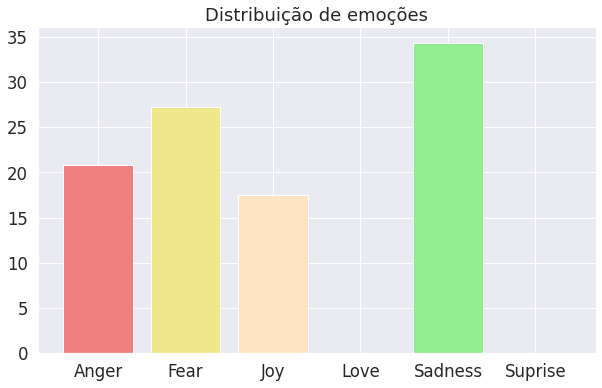

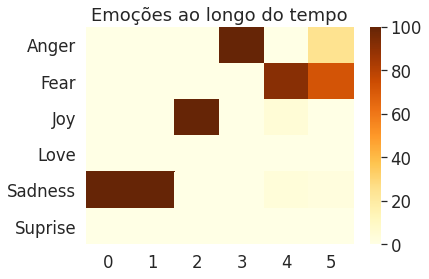

In [88]:
visualizar_user('Noname83661988')

##True Negative

In [89]:
Ytrue0 = Y_test.detach().cpu().numpy() == 0
Ypred0 = Y_pred.detach().cpu().numpy().round() == 0

In [90]:
X_test_df[Ytrue1.reshape(-1) & Ypred1.reshape(-1)]  #Onde era verdadeirofalso e foi previsto falso  (True negative)

,user,tweets,depression
190,JTdeMoraes,"[Antologia Acústica de Zé Ramalho https://t.co/2YHr1qE6R2 #NowPlaying, cerveja pra curar a ressaca do plantão super indico, Veja esta foto do Instagram de @epidemioinformacao https://t.co/voGYK0pQa5, É o seguinte, ando pensando, em como retomar minha vida acadêmica perdida nesses últimos três anos que descobri a depressão. Quero só chorar, mesmo com 2 anos de tratamento, não tenho forças. Meu dda se perde no perfeccionismo e me vejo fracassar. #saudemental #SetembroAmarelo, Tudo pronto! Daqui a 30 minutinhos vai sair um delicioso bolo de coco low carb, pena que vou comer sozinha com um maravilhoso café (deboche para quem me deixou por um hambúrguer).\r\n\r\nSim, eu sou recalcada!]",1
201,onmysblock,"[eu me sinto tão impotente vendo isso pq eu não posso fazer mais nada alem de assinar uma petição e isso me destrói \r\nricardo salles seu vagabundo de merda espero q vc morra queimado seu verme dos infernos @rsallesmma https://t.co/NrI22mucG5, essa é pra refletir https://t.co/gXbkMUFm4w, acabei de ver into the night e nossa amei eu tava esperando uma versão ruim de manifest mas não tem nada a ver, Tenho 21 anos e sofro de depressão à 3 anos.\r\nentão vou fazer uma promessa a cada rtt que tiver vai ser 1 dia ke sentir deprimida e toda vez que eu sentir triste, vou pegar uma das pessoas que deu rtt e vou agradecer\r\nex : ( obrigada @ por ter salvo a minha vida ), qnd entrou um no meu ouvido em 2017 eu fui na médica e ela jogou um jato de água com uma seringa pra ele sair fiquei tontissima https://t.co/CDkY0xsAjO]",1
295,CaetanoVf,"[cara eu olhando pra foto dela ontem me apaixonei mais ainda, gg diagnósticado com depressão e vai lá e minha mae me ajuda falando q eu só fico no quarto o dia inteiro e q eu n fasso nd e q sou um vagabundo aaaa vou pular da ponte vey n to alguéntanto, ela é perfeita PERFEITA aaaaaa, minha meta era contatos de A a Z mal cheguei no a e me apaixonei, toma no cu ta ansioso pra caralho pra me declarar pra ela se fude]",1
276,luaratizot,"[acabei de me tocar que eu não faço as atividades do ead tem mais de duas semanas eu vou morrer jesus amado simplesmente esqueci que ainda faço faculdade, as coisas que eu mais amo no mundo minha familia minha cachorra os bts, SETENTA E QUATRO PORCENTO MAIOR https://t.co/GLecwBZFGJ, que agonia olhar os stories do instagram e perceber que tá todo mundo saindo, MEU DEUS EU ODEIO ESSE FILHO DA PUTA RACISTA DESGRAÇADO VAI TOMAR NO MEIO DO SEU CU SEU IDIOTA https://t.co/sDMDQYoApv, mesmo com a porcaria de um vídeo de um homem negro sendo assassinado por racistas o povo consegue negar o fato ""tirar o racismo"" da situação resumindo ela a um assassinato qualquer que aconteceu por motivo qualquer tomar no meio do meu cu bando de racista negacionista do inferno]",1
159,oitoouoitent4,"[eu gosto de cuidar dos outros e ser o melhor que posso pra vida dos outros. smp penso que, se posso deixar a vida de alguém mais leve, pq não? \r\n\r\no problema é que, comumente, eu esqueço de mim..., às vezes, eu só sinto que não tenho ngm... que não tenho lugar nesse mundo, nessa vida, lendo meu diário de qnd eu tinha 11 anos confirmei que tenho depressão desde sempre, eu já prometi pra mim mesma tantas e tantas vezes que eu não iria mais me despedaçar, e eu detesto ser essa garota bad vibes, to cansada de caminhar, de insistir...]",1
...,...,...,...
237,ggukpersona,"[minhas tracks das últimas 4 semanas assim de saúde o the weeknd barrou o bts de tanto que eu ouço die for you https://t.co/41483FM8v2, eu: mae tenho depressão e me sinto um lixo na maioria do tempo nn consigo levantar da cama em alguns dias pfv nn me cobra mto as coisas de casa eu sei que eu preciso fazer mas tenta me entender\r\n\r\nela: mas vc já tentou sorrir😃? já tentou levantar da cama😃? lava a louça que passa, HEY BRO THIS YOU BRO??? THIS YOU??? https://t.co/52lHedOOFh]",1
127,Amanda07891512,"[#Insônia \r\n#Ansiedade \r\n#Depressão\r\n\r\nTem sido dias difíceis. 🎗, #WakandaForever \r\n#Panter

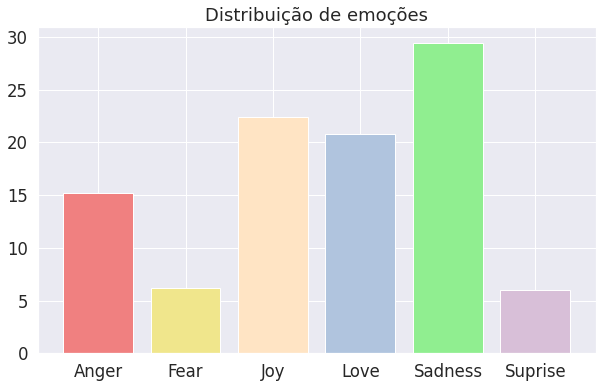

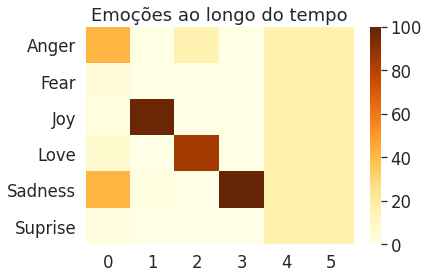

In [91]:
visualizar_user('vitoriaomena777')

## Exportando o modelo

In [92]:
torch.save(Model, cwd+f'/../models/depression_detection.pth')

In [93]:
torch.save(Model.state_dict(), cwd+f'/../dicts/depression_detection.dict')